In [1]:
from os import listdir, path
import shutil

import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, Precision, Recall, F1Score

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms

from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

#### Define train path

In [2]:
#convert to RGBA first because of error Projects/Fruit and veg/myenv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
#warnings.warn(

PATH =  "../RGBAKaggleData"
train_path = PATH + "/train"
test_path = PATH + "/test"
val_path = PATH + "/validation"

In [3]:
class_counts = {}

for class_name in listdir(train_path):  # Loop through class subdirectories
    class_path = path.join(train_path, class_name)
    if path.isdir(class_path):  # Ensure it's a directory
        num_images = len([f for f in listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        class_counts[class_name] = num_images

# Print the results
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

apple: 68 images
turnip: 97 images
raddish: 81 images
bell pepper: 89 images
pear: 89 images
sweetpotato: 69 images
pomegranate: 78 images
peas: 100 images
spinach: 97 images
lettuce: 97 images
kiwi: 88 images
lemon: 82 images
onion: 94 images
cauliflower: 79 images
potato: 76 images
sweetcorn: 91 images
cucumber: 94 images
watermelon: 84 images
mango: 86 images
cabbage: 91 images
grapes: 100 images
beetroot: 87 images
eggplant: 84 images
corn: 87 images
soy beans: 97 images
banana: 75 images
ginger: 68 images
garlic: 92 images
pineapple: 98 images
tomato: 92 images
orange: 69 images
carrot: 81 images


In [4]:
#On review, these classes are simmilar, do not make sense or will cause confusion and can be removed. Bell pepper is retained
classes_to_remove = ("chilli pepper", "capsicum", "paprika", "jalepeno")

# Function to remove directories
def remove_classes(dataset_path, classes_to_remove):
    for class_name in listdir(dataset_path):
        class_dir = path.join(dataset_path, class_name)
        if path.isdir(class_dir) and class_name in classes_to_remove:
            shutil.rmtree(class_dir)  # Deletes the entire folder
           


remove_classes(train_path, classes_to_remove)
remove_classes(test_path, classes_to_remove)
remove_classes(val_path, classes_to_remove)

In [5]:
number_of_classes = len(listdir(train_path))
print(number_of_classes)

32


#### Load dataset

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 32

train_dataset = datasets.ImageFolder(train_path, transform= transform)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = datasets.ImageFolder(test_path, transform= transform)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

val_dataset = datasets.ImageFolder(val_path, transform= transform)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= True)


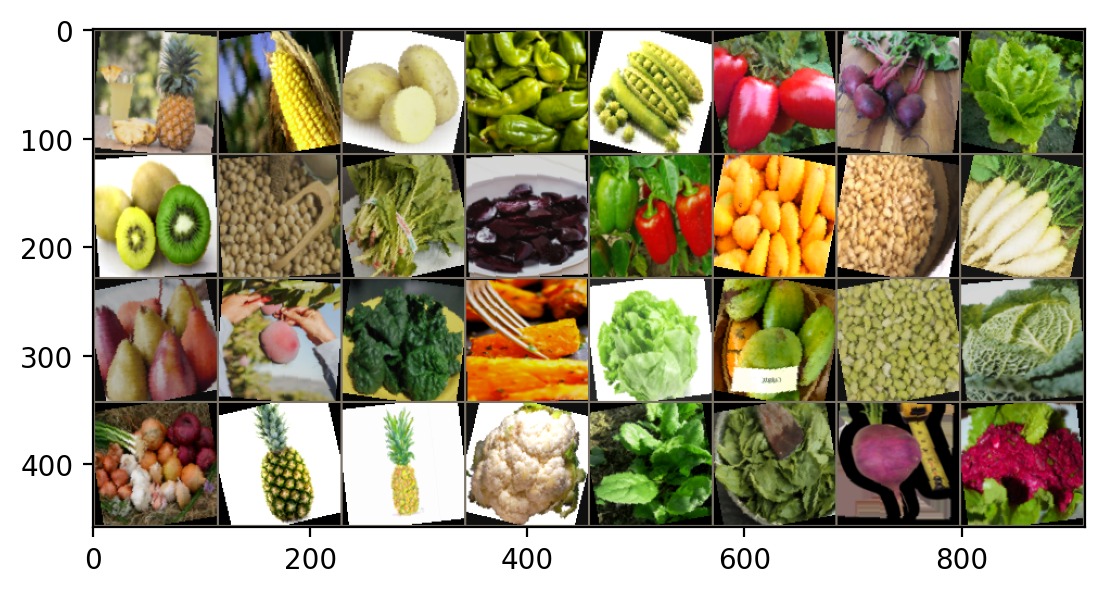

In [7]:
def imshow(img):
    # Unnormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    img = img * std[:, None, None] + mean[:, None, None]  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

#### Define Neural Network


In [8]:
print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU with MPS backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

PyTorch Version: 2.6.0
TorchVision Version: 0.21.0
Using GPU with MPS backend.


In [9]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding= 1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding= 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2) 

        self.fc1 = nn.Linear(100352, 512)  
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) 
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net(num_classes=number_of_classes)
input_size = (3,112,112)
summary(net, input_size)
net = net.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 64, 112, 112]          18,496
       BatchNorm2d-4         [-1, 64, 112, 112]             128
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]          73,856
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Linear-9                  [-1, 512]      51,380,736
          Dropout-10                  [-1, 512]               0
           Linear-11                   [-1, 32]          16,416
Total params: 51,490,848
Trainable params: 51,490,848
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Fo

#### Define loss function and optimiser

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay = 1e-4)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience = 3, factor =0.5)

#### Train the model

In [11]:
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []
total_iterations = len(train_dataloader)
for epoch in range(100):  
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total = total_iterations, ncols = 100, desc=f"Epoch {epoch+1}", leave =False):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}')

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            val_loss +=loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(net.state_dict(), 'my_best_model.pth')
    else:
        counter+=1   
        #print(f"Early stopping counter: Epoch {epoch +1} - {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered: {epoch +1}")
            break

print('Finished Training')

Early stopping triggered: 46
Finished Training


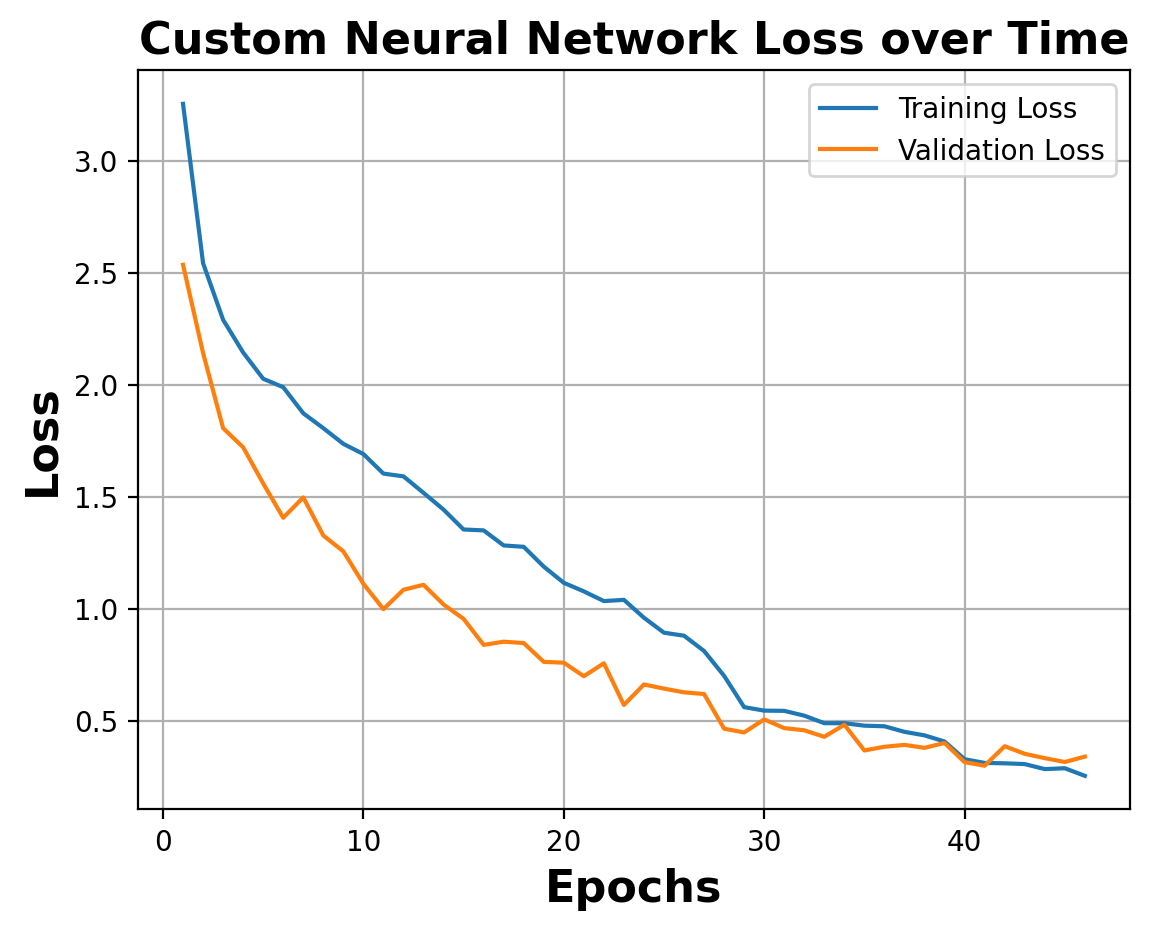

In [12]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1,len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.title('Custom Neural Network Loss over Time', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.savefig("../Results/LossEachEpoch.png", format='png', bbox_inches='tight')
plt.show()


## Test

In [13]:
# Initialize metrics
accuracy = MulticlassAccuracy(num_classes=number_of_classes).to(device)  
precision = Precision(num_classes= number_of_classes, task="multiclass").to(device)
recall = Recall(num_classes=number_of_classes, task="multiclass").to(device)
f1_score = F1Score(num_classes=number_of_classes, task="multiclass").to(device)

In [14]:
all_test_preds = []
all_test_labels = []
classes = test_dataloader.dataset.classes

with torch.no_grad():
    for test_data in test_dataloader:
        test_inputs,test_labels = test_data
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = net(test_inputs)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        _, test_predicted = torch.max(test_outputs, 1)
        
        all_test_preds.extend(test_predicted.cpu().numpy())
        all_test_labels.extend(test_labels.cpu().numpy())

# Print a detailed classification report
print(metrics.classification_report(all_test_labels, all_test_preds, target_names=classes))

              precision    recall  f1-score   support

       apple       0.86      0.60      0.71        10
      banana       1.00      0.78      0.88         9
    beetroot       0.90      0.90      0.90        10
 bell pepper       0.83      1.00      0.91        10
     cabbage       1.00      1.00      1.00        10
      carrot       0.91      1.00      0.95        10
 cauliflower       1.00      1.00      1.00        10
        corn       0.70      0.70      0.70        10
    cucumber       1.00      0.90      0.95        10
    eggplant       1.00      1.00      1.00        10
      garlic       0.91      1.00      0.95        10
      ginger       0.91      1.00      0.95        10
      grapes       0.91      1.00      0.95        10
        kiwi       0.91      1.00      0.95        10
       lemon       0.91      1.00      0.95        10
     lettuce       1.00      0.90      0.95        10
       mango       1.00      0.90      0.95        10
       onion       0.91    

## Validation

In [15]:
all_val_preds = []
all_val_labels = []
classes = val_dataloader.dataset.classes

with torch.no_grad():
    for val_data in val_dataloader:
        val_inputs, val_labels = val_data
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = net(val_inputs)
        _, val_predicted = torch.max(val_outputs, 1)
        
        all_val_preds.extend(val_predicted.cpu().numpy())
        all_val_labels.extend(val_labels.cpu().numpy())


print(metrics.classification_report(all_val_labels, all_val_preds, target_names=classes))

              precision    recall  f1-score   support

       apple       1.00      0.70      0.82        10
      banana       1.00      0.78      0.88         9
    beetroot       0.91      1.00      0.95        10
 bell pepper       0.82      1.00      0.90         9
     cabbage       1.00      0.80      0.89        10
      carrot       1.00      1.00      1.00         9
 cauliflower       0.83      1.00      0.91        10
        corn       0.70      0.70      0.70        10
    cucumber       1.00      0.90      0.95        10
    eggplant       1.00      0.80      0.89        10
      garlic       0.91      1.00      0.95        10
      ginger       0.89      0.80      0.84        10
      grapes       0.82      1.00      0.90         9
        kiwi       0.91      1.00      0.95        10
       lemon       0.91      1.00      0.95        10
     lettuce       1.00      0.89      0.94         9
       mango       1.00      1.00      1.00        10
       onion       1.00    

/var/folders/c4/7_8kw6qj6cddjhxtp_bc37t00000gn/T/ipykernel_25190/898923396.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='F1 Score', data=f1_data, palette= colours)


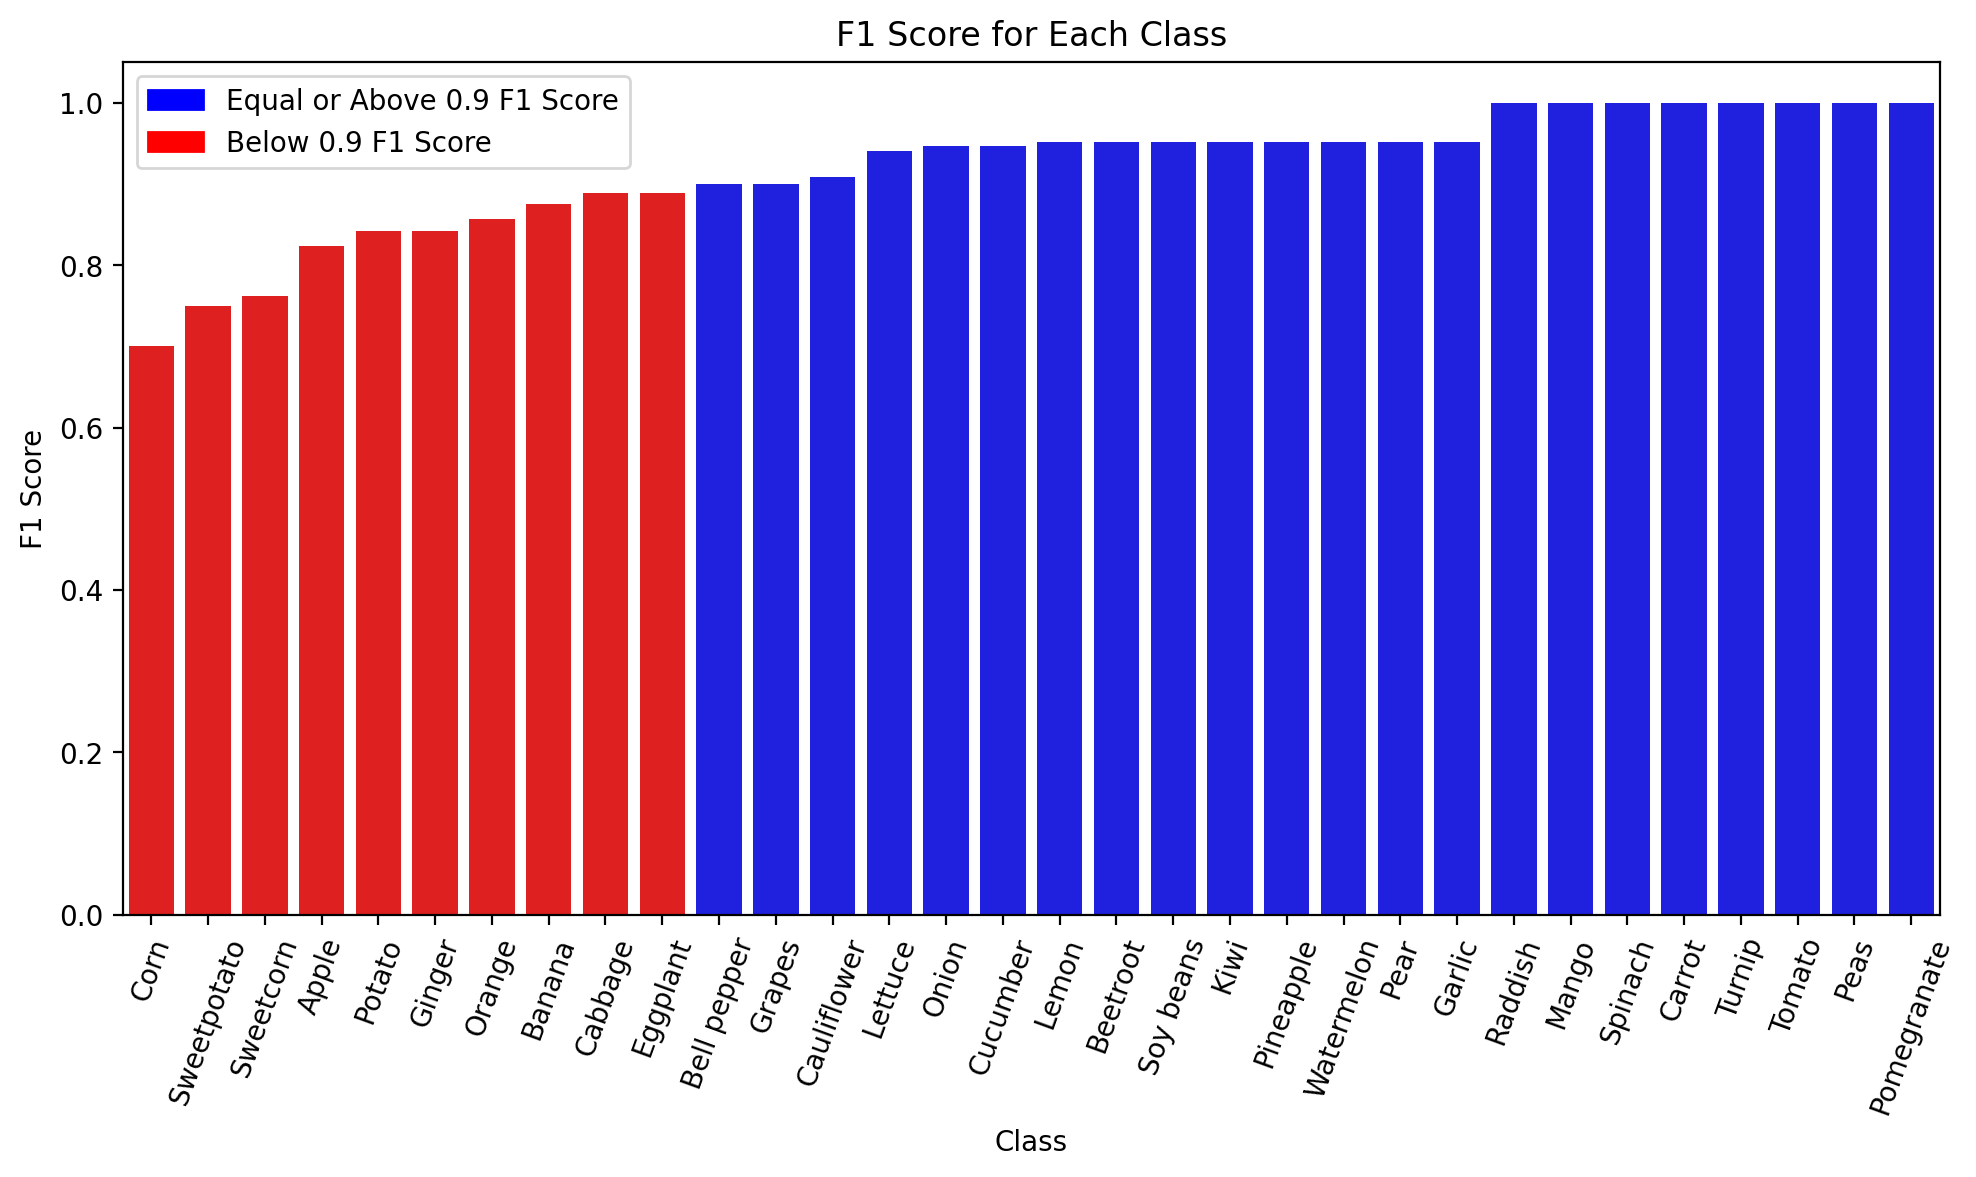

In [22]:
threshold = 0.9
report = metrics.classification_report(all_val_labels, all_val_preds, target_names=classes, output_dict=True)
f1_scores = {key: report[key]['f1-score'] for key in report if key not in ['accuracy', 'macro avg', 'weighted avg']}
f1_data = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])
f1_data = f1_data.sort_values(by='F1 Score')
f1_data['Class'] = f1_data['Class'].str.capitalize()

plt.figure(figsize=(10,6))
colours = ['red' if acc < threshold else 'blue' for acc in f1_data['F1 Score']]
sns.barplot(x='Class', y='F1 Score', data=f1_data, palette= colours)
above_threshold_patch = mpatches.Patch(color='blue', label=f"Equal or Above {threshold} F1 Score")
below_threshold_patch = mpatches.Patch(color='red', label=f"Below {threshold} F1 Score")
plt.legend(handles=[above_threshold_patch, below_threshold_patch])
plt.xticks(rotation=70)
plt.title('F1 Score for Each Class')
plt.ylabel('F1 Score')
plt.xlabel('Class')

plt.tight_layout()
plt.savefig("../results/f1_score_per_class.png", format='png')
plt.show()

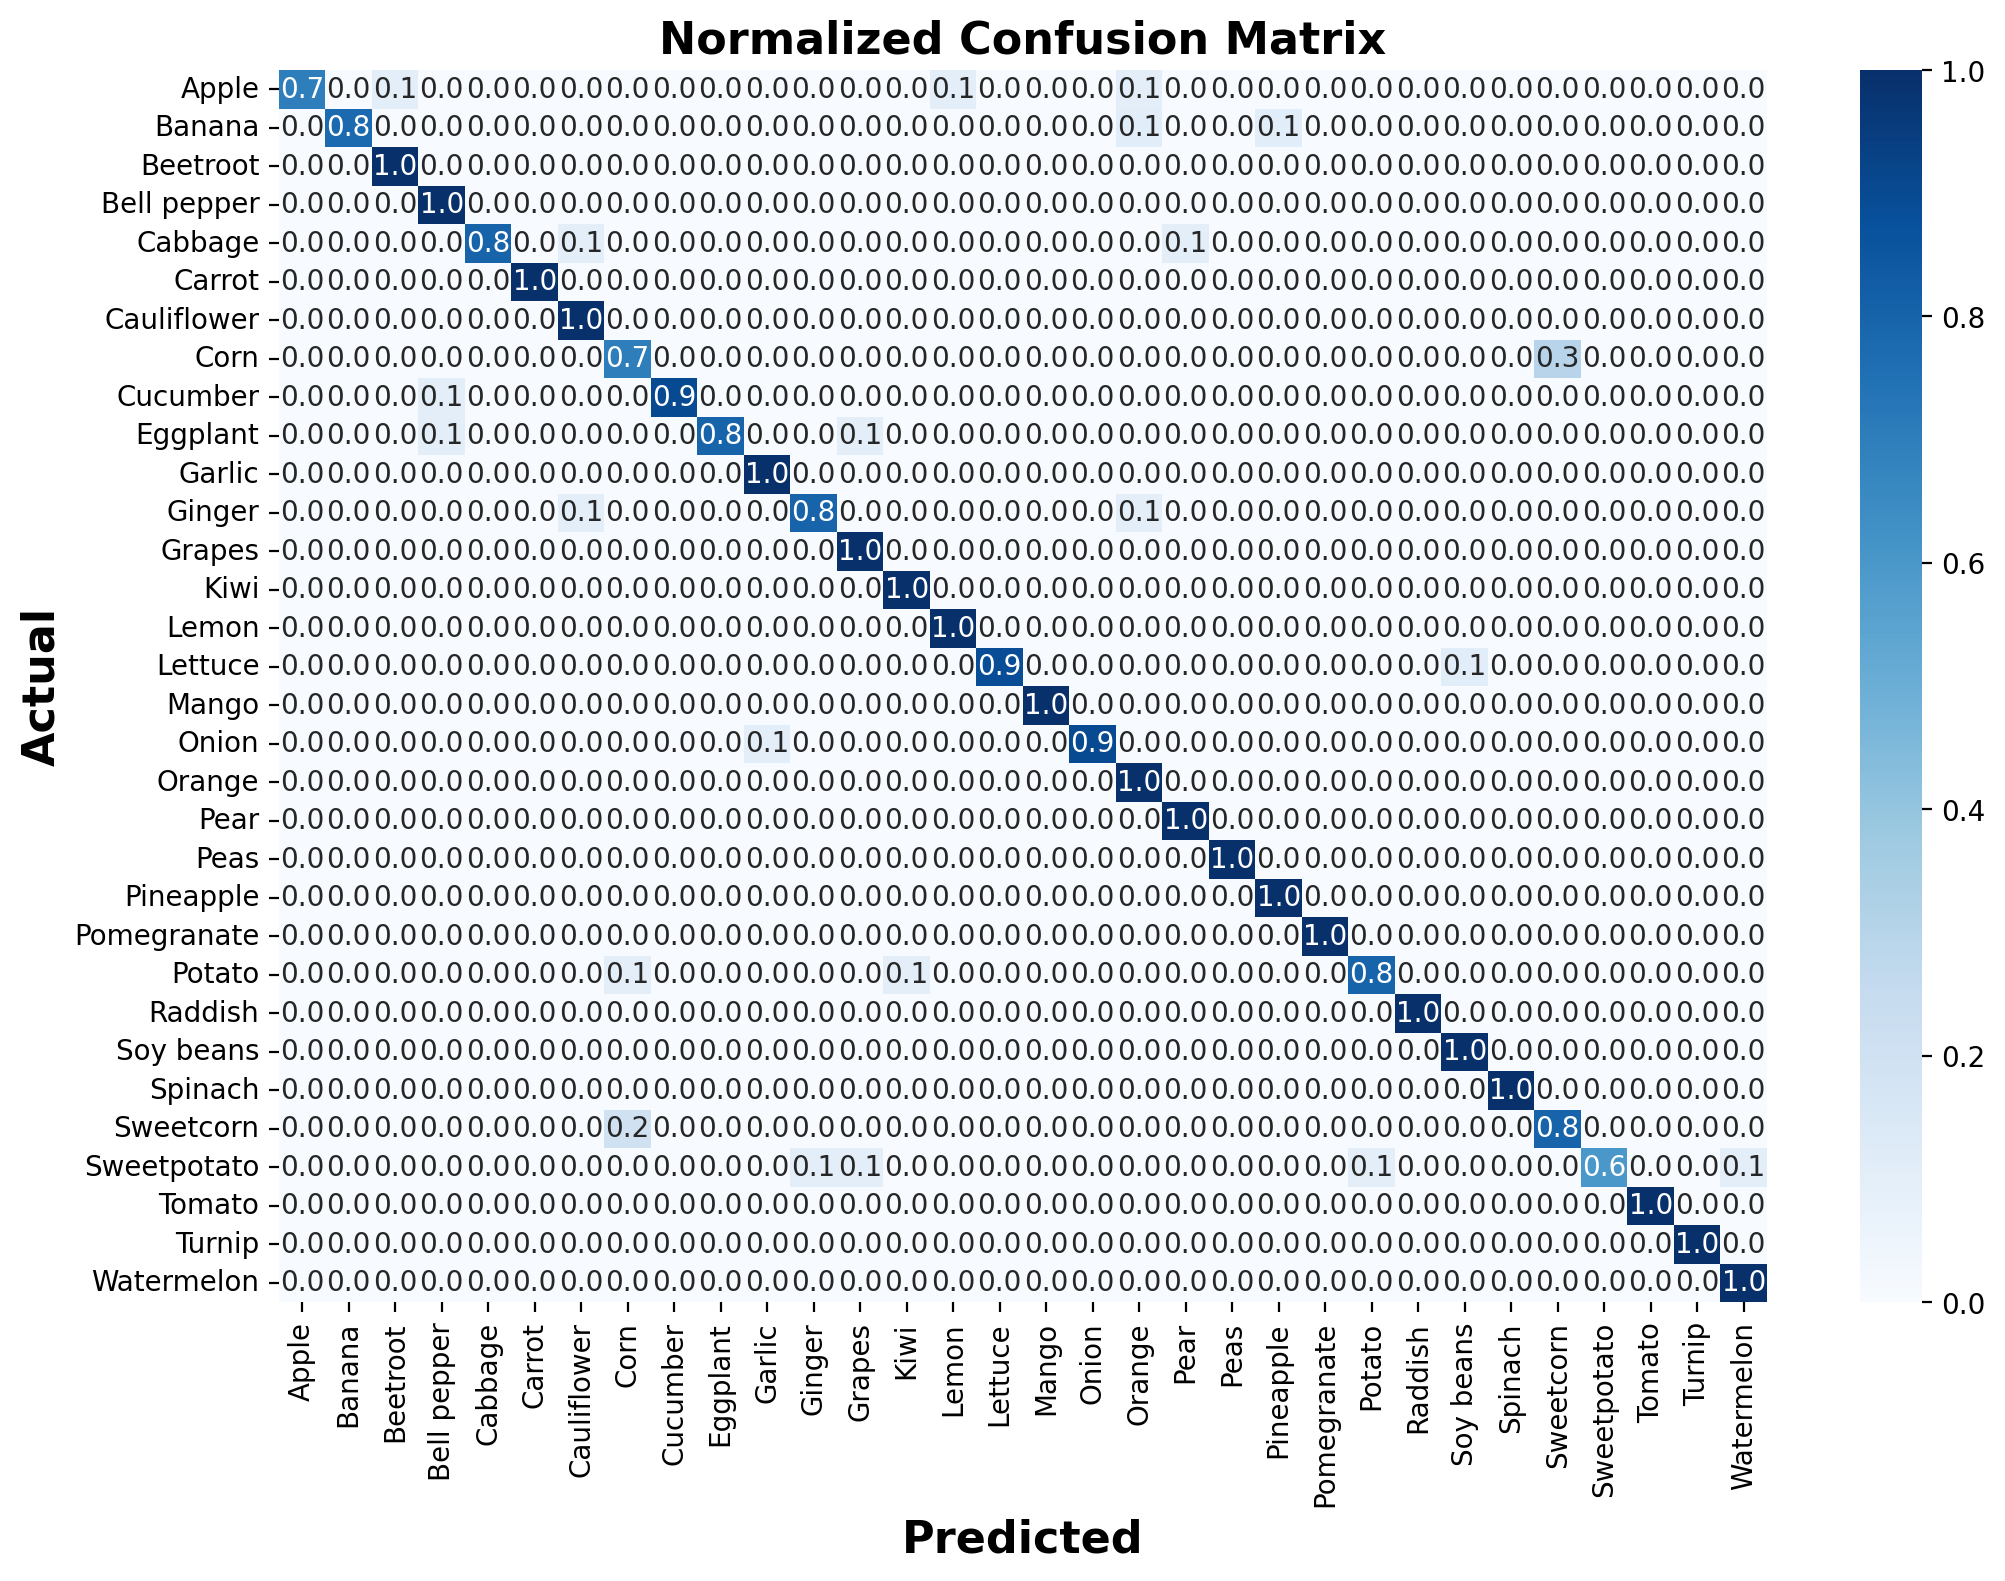

In [17]:
cm = metrics.confusion_matrix(all_val_labels, all_val_preds)
cm_normalised = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_normalised = np.nan_to_num(cm_normalised)

class_names = val_dataloader.dataset.classes
class_names = [class_name.capitalize() for class_name in class_names]

plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalised, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=16, fontweight='bold')
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')

plt.savefig("../Results/ConfusionMatrix.png", format='png', bbox_inches='tight')
plt.show()

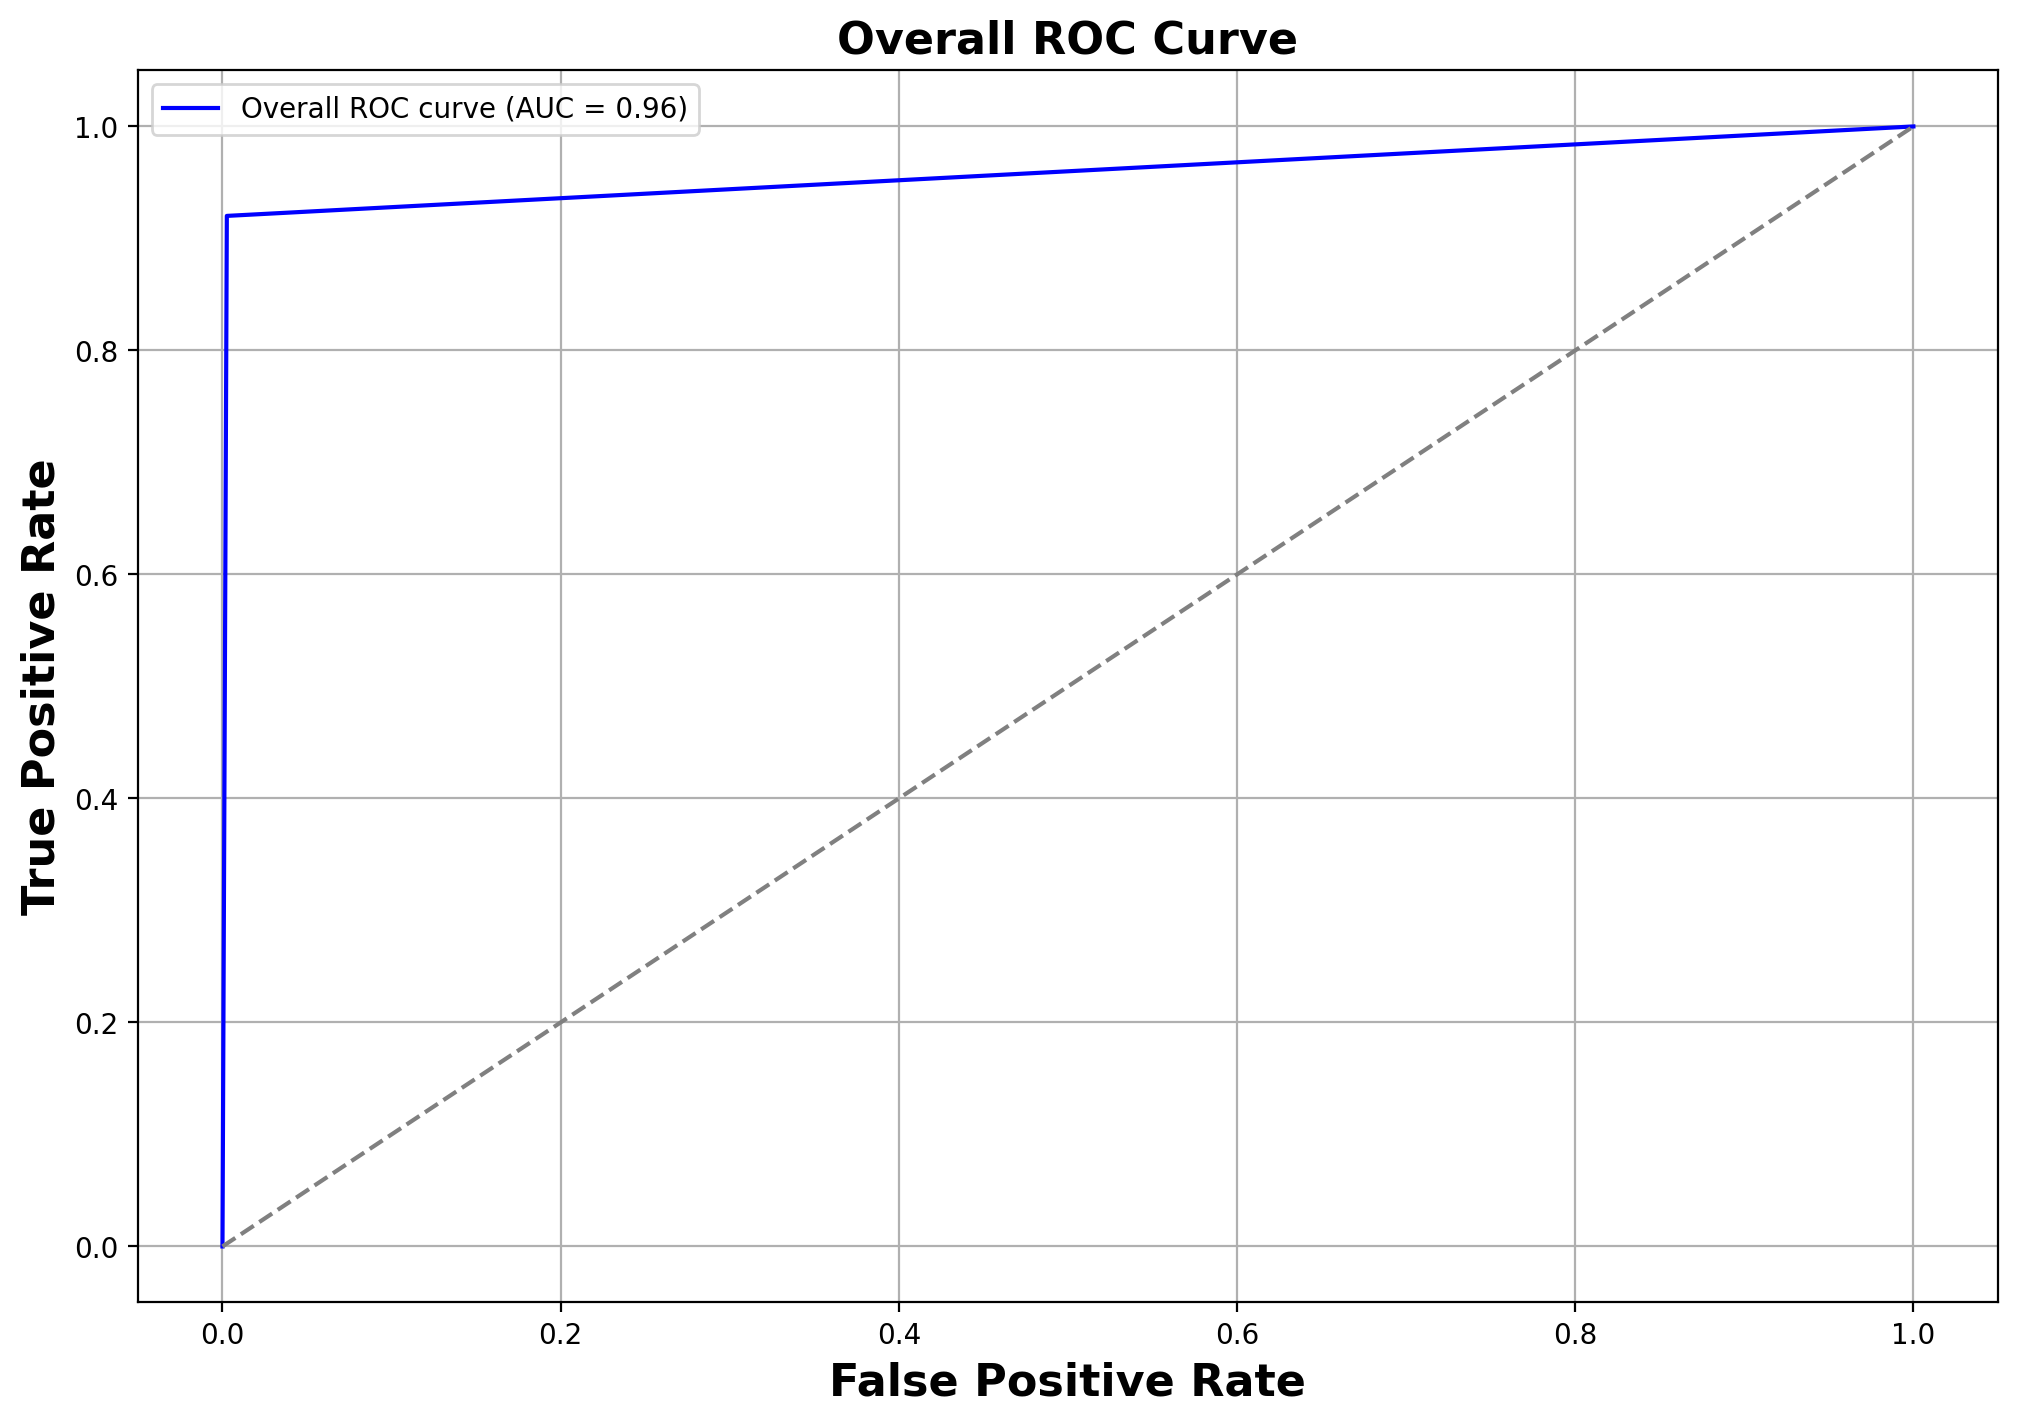

In [18]:
y_true_bin = label_binarize(all_val_labels, classes=range(len(classes)))
y_pred_bin = label_binarize(all_val_preds, classes=range(len(classes)))
fpr, tpr, _ = metrics.roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color="blue", label=f"Overall ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate", fontsize=16, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=16, fontweight='bold')
plt.title("Overall ROC Curve", fontsize=16, fontweight='bold')
plt.legend()
plt.grid()
plt.savefig("../Results/RocCurve.png", format='png', bbox_inches='tight')
plt.show()

# Save Model

In [19]:
model_file_name = "my_best_model.pth"
#torch.save(net.state_dict(),model_file_name)

source = model_file_name
destination = "../" + model_file_name

#copy model to the directory that can be used by the main.py file
with open(source, "rb") as src, open(destination, "wb") as dest:
    while chunk := src.read(4096):  
        dest.write(chunk)
